# Naive models

Implements 2 naive models:  
- NaiveLag
- NaiveRollingMean

In [1]:
import seaborn as sns
import pandas as pd

import utils.utils as utils
import utils.utils_features as utils_features
import utils.utils_preprocessing as utils_preprocessing
import utils.utils_plots as utils_plots
from utils.utils_models import NaiveRollingMean, NaiveLag
from sklearn.model_selection import TimeSeriesSplit

sns.set_theme(style="darkgrid")

In [2]:
file_path = 'train_v_2_kaggle_23.csv'
df_kaggle = pd.read_csv(file_path)

df_kaggle = utils_preprocessing.preprocess_columns(df_kaggle)
df_kaggle = utils_preprocessing.fill_in_missing_dates(df_kaggle)
df_kaggle = df_kaggle.groupby('sku', group_keys=False, observed=False).apply(utils_preprocessing.interpolate)
df_kaggle = utils_features.features_time_related(df_kaggle)
df_kaggle = utils_features.features_lag(df=df_kaggle, col='inventory_units', lags=[13])
df_kaggle = utils_features.features_lag(df=df_kaggle, col='sales_units', lags=[13, 14, 15])
df_kaggle = utils_features.features_rolling(df=df_kaggle, col='inventory_units', window_sizes=[4, 8])
df_kaggle = utils_features.features_rolling(df=df_kaggle, col='sales_units', window_sizes=[4, 8])

df_kaggle = df_kaggle.rename(columns={'inventory_units': 'y'}).set_index('date').sort_index()

df_kaggle = df_kaggle.dropna()

df_kaggle = df_kaggle.rename(columns={'inventory_units': 'y'})#.set_index('date').sort_index()

/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_46577/3092408702.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_kaggle = df_kaggle.groupby('sku', group_keys=False, observed=False).apply(utils_preprocessing.interpolate)


In [3]:
df_kaggle.columns

Index(['sku', 'id', 'year_week', 'product_number', 'reporterhq_id',
       'prod_category', 'display_size', 'segment', 'sales_units', 'y',
       'day_of_month', 'week_of_month', 'week_of_year', 'month_of_year',
       'year', 'sin_day_of_month', 'cos_day_of_month', 'sin_week_of_year',
       'cos_week_of_year', 'sin_month_of_year', 'cos_month_of_year',
       'inventory_units_lag_13', 'sales_units_lag_13', 'sales_units_lag_14',
       'sales_units_lag_15', 'inventory_units_rolling_mean_4w',
       'inventory_units_rolling_std_4w', 'inventory_units_rolling_sum_4w',
       'inventory_units_rolling_mean_8w', 'inventory_units_rolling_std_8w',
       'inventory_units_rolling_sum_8w', 'sales_units_rolling_mean_4w',
       'sales_units_rolling_std_4w', 'sales_units_rolling_sum_4w',
       'sales_units_rolling_mean_8w', 'sales_units_rolling_std_8w',
       'sales_units_rolling_sum_8w'],
      dtype='object')

### Validate the last 13*2 weeks

In [4]:
df_kaggle.columns

Index(['sku', 'id', 'year_week', 'product_number', 'reporterhq_id',
       'prod_category', 'display_size', 'segment', 'sales_units', 'y',
       'day_of_month', 'week_of_month', 'week_of_year', 'month_of_year',
       'year', 'sin_day_of_month', 'cos_day_of_month', 'sin_week_of_year',
       'cos_week_of_year', 'sin_month_of_year', 'cos_month_of_year',
       'inventory_units_lag_13', 'sales_units_lag_13', 'sales_units_lag_14',
       'sales_units_lag_15', 'inventory_units_rolling_mean_4w',
       'inventory_units_rolling_std_4w', 'inventory_units_rolling_sum_4w',
       'inventory_units_rolling_mean_8w', 'inventory_units_rolling_std_8w',
       'inventory_units_rolling_sum_8w', 'sales_units_rolling_mean_4w',
       'sales_units_rolling_std_4w', 'sales_units_rolling_sum_4w',
       'sales_units_rolling_mean_8w', 'sales_units_rolling_std_8w',
       'sales_units_rolling_sum_8w'],
      dtype='object')

In [5]:
fc_model_rolling = NaiveRollingMean(hyperparameters={'window': 4})
results_cv = fc_model_rolling.cross_validate(df_kaggle, n_splits=2, bottom_up=True)

/Users/matteogiaretti/Python/hp_use_case/utils/utils_models.py:122: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X.sort_index().groupby("sku")[self.column].last().to_dict()
/Users/matteogiaretti/Python/hp_use_case/utils/utils_models.py:122: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X.sort_index().groupby("sku")[self.column].last().to_dict()


Average RMSE from cross-validation: 57.0860

Average RMSE after aggregating per id: 76.0620


In [6]:
fc_model_lag = NaiveLag(hyperparameters={'lag': 13})
results_cv = fc_model_lag.cross_validate(df_kaggle, n_splits=2)

/Users/matteogiaretti/Python/hp_use_case/utils/utils_models.py:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X.sort_index().groupby("sku")[self.column].last().to_dict()
/Users/matteogiaretti/Python/hp_use_case/utils/utils_models.py:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X.sort_index().groupby("sku")[self.column].last().to_dict()


Average RMSE from cross-validation: 58.9265

Average RMSE after aggregating per id: 82.2530


### Plot results for the last 13 weeks

In [7]:
X_train, X_test, y_train, y_test = utils.train_test_split(df_kaggle, forecasting_horizon=13, target_col="y")

In [8]:
fc_model_rolling = NaiveRollingMean(hyperparameters={'window': 4})
fc_model_rolling.train(X_train, y_train)

fc_model_lag = NaiveLag(hyperparameters={'lag': 13})
fc_model_lag.train(X_train, y_train)

In [9]:
df_preds_rolling = utils.predict_last_13_weeks(df_kaggle, fc_model_rolling)
df_preds_lag = utils.predict_last_13_weeks(df_kaggle, fc_model_lag)

df_final = df_kaggle.merge(df_preds_rolling.reset_index(), on=['date', 'sku'], how='left')

/Users/matteogiaretti/Python/hp_use_case/utils/utils_models.py:122: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X.sort_index().groupby("sku")[self.column].last().to_dict()
/Users/matteogiaretti/Python/hp_use_case/utils/utils_models.py:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X.sort_index().groupby("sku")[self.column].last().to_dict()


In [10]:
temp = df_preds_lag.reset_index().merge(df_preds_rolling, on=['date', 'sku'], suffixes=['_lag', '_rolling'])
df_final = df_kaggle.merge(temp, on=['date', 'sku'], how='left')[['date', 'sku', 'product_number', 'year_week', 'id', 'y', 'y_pred_lag', 'y_pred_rolling']]
vline_dates = [df_final['date'].max() - pd.DateOffset(weeks=13)]

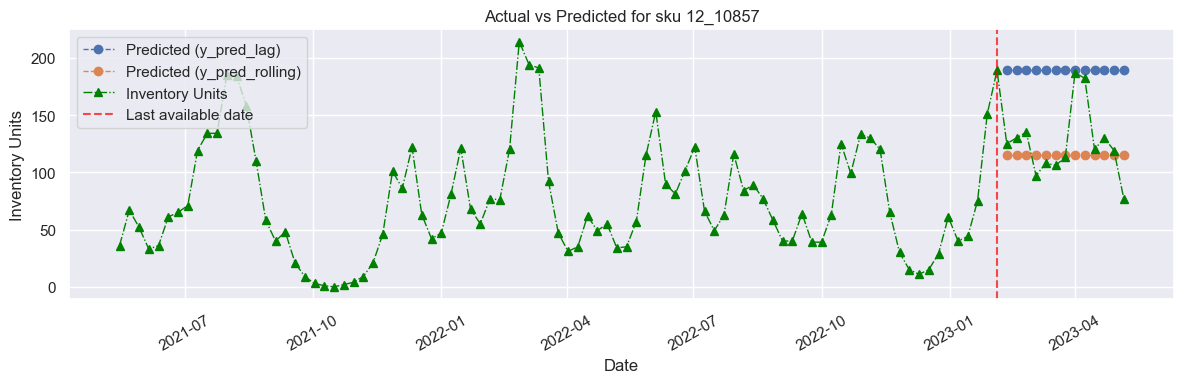

In [11]:
utils_plots.plot_real_vs_predicted(df_final, single_ts='12_10857', pred_columns=['y_pred_lag', 'y_pred_rolling'], vline_dates=vline_dates)

In [12]:
num_select = 4
#list_skus = np.random.choice(df_preds_rolling['sku'].unique(), size=num_select, replace=False) # Random
list_skus = df_preds_rolling["sku"].cat.remove_unused_categories().value_counts().index[:num_select].values # More entries in the dataset
#list_skus = df_preds_rolling["sku"].cat.remove_unused_categories().value_counts().index[-num_select:].values # Less entries in the dataset

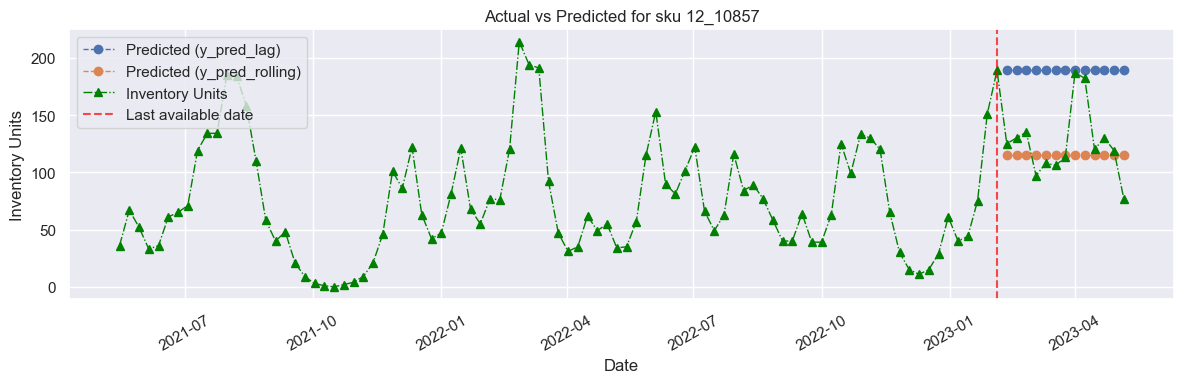

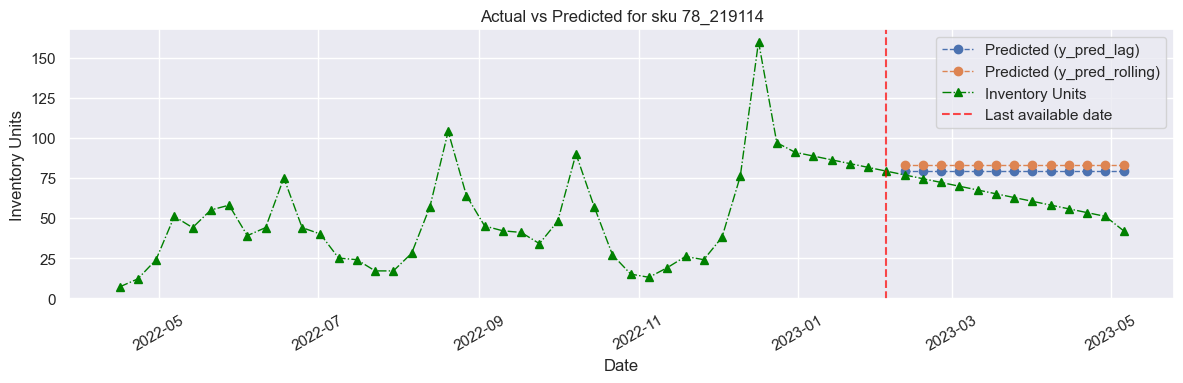

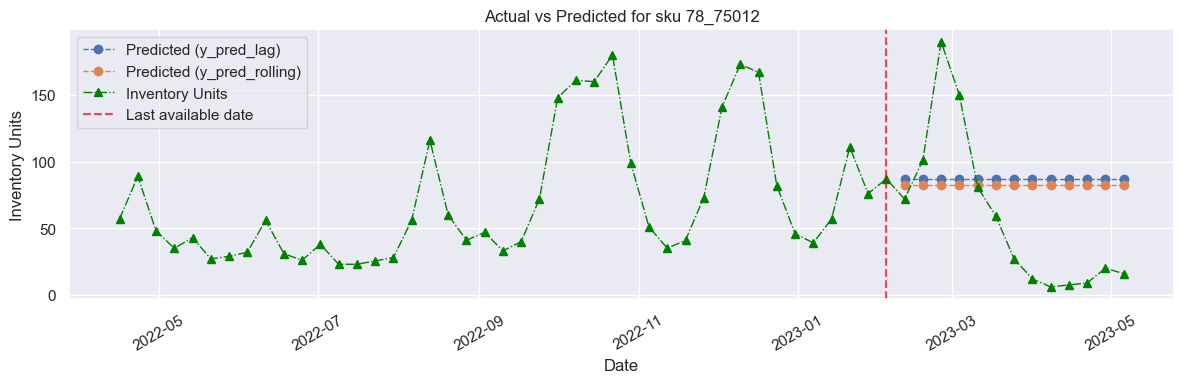

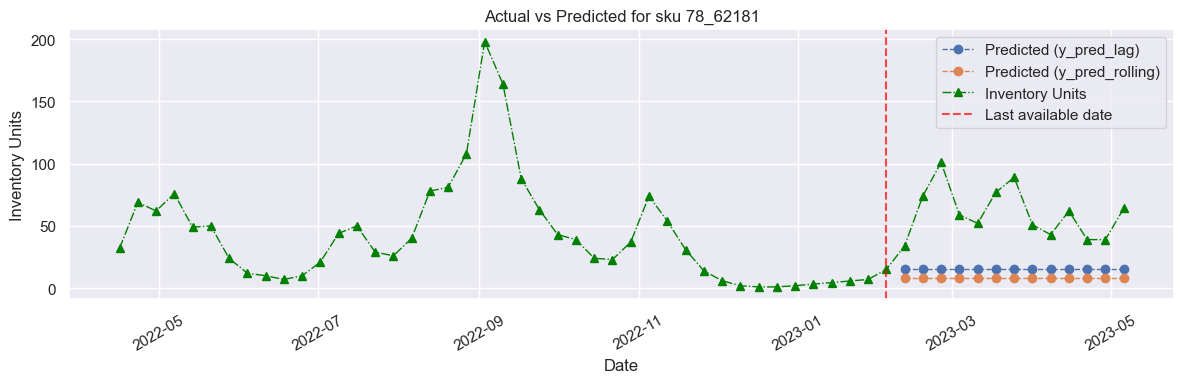

In [13]:
date_present = df_final['date'].max() - pd.DateOffset(weeks=13)
for sku in list_skus:
    utils_plots.plot_real_vs_predicted(df_final, sku, pred_columns=['y_pred_lag', 'y_pred_rolling'], vline_dates=[date_present])

### Aggregated predictions

In [14]:
df_aggregated = utils.aggregate_predictions(df_final, cols=['y_pred_lag', 'y_pred_rolling'])

In [15]:
df_aggregated

,id,date,year_week,product_number,y,y_pred_lag,y_pred_rolling
0,202239-2961,2022-10-01,202239.0,2961,63.0,0.0,0.00
1,202240-2961,2022-10-08,202240.0,2961,103.0,0.0,0.00
2,202241-2961,2022-10-15,202241.0,2961,138.0,0.0,0.00
3,202242-2961,2022-10-22,202242.0,2961,139.0,0.0,0.00
4,202243-2961,2022-10-29,202243.0,2961,87.0,0.0,0.00
...,...,...,...,...,...,...,...
12691,202314-248724,2023-04-08,202314.0,248724,119.0,111.5,138.75
12692,202315-248724,2023-04-15,202315.0,248724,143.0,111.5,138.75
12693,202316-248724,2023-04-22,202316.0,248724,187.5,111.5,138.75
12694,202317-248724,2023-04-29,202317.0,248724,274.0,111.5,138.75


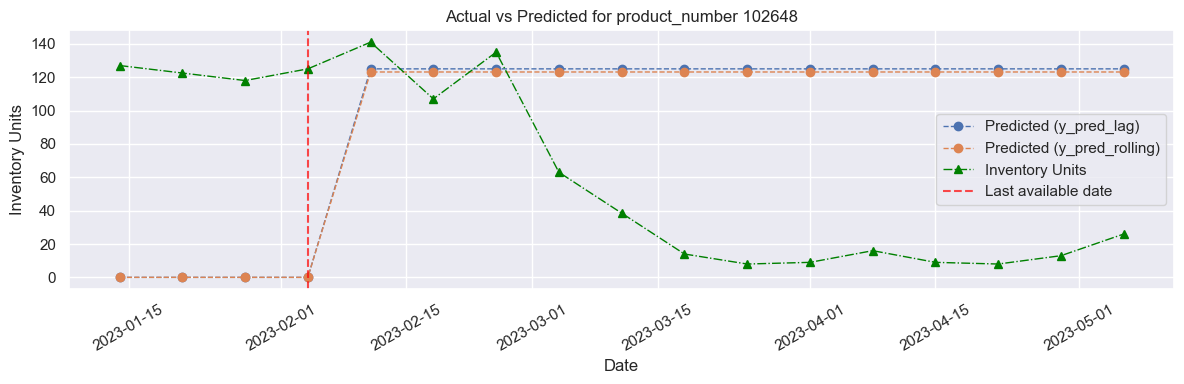

In [16]:
utils_plots.plot_real_vs_predicted(df_aggregated, single_ts=102648, pred_columns=['y_pred_lag', 'y_pred_rolling'], col_agg='product_number', vline_dates=[date_present])